In [1]:
bayesplay::loadpackages()

# Criticisms of *p* values

People have written lots of criticism of *p*-values. A lot of these are of the form "*p*-values are bad because they don't do X", where X is not a design feature of frequentist inference.   I'm not interested in these kinds of criticisms, because they seem pretty meaningless.  Instead, I think that we are going to criticise *p*-values it is better to look at the design features of frequentist inference and find fault there. 

So what are the design features? In the last section, we saw how frequentist inference was *very* good at controlling the kinds of mistakes we made in our treasure hunt.  To do this, all we needed was a model of how our treasure detecting device operated. If we only wanted to control *false positives* all we needed was a model of how it operated in the absence of treasure. To build this model, we just need one bit of information—that the dial *on average* pointed at 0 when there was no treasure. The whole model could then be built up by running lots of simulations (or pretend experiments) where this parameter (the average reading in the absence of treasure) was the only parameter we needed to set. That's a pretty powerful property. And we get it all from running imaginary experiments!

## Same measurements from different devices 

Now let's imagine a new scenario. As before, you have a treasure hunting device (we'll call it $D_1$). You're using $D_1$ to hunt treasure, using the readings to decide whether to dig or not. At your first treasure hunting spot, you record the measurements: 1,  0,  1,  3,  0,  1,  4, -1,  3,  4. You then average, and scale these measurements and get a *t* value of approximately 2.848. You compare this to what you found in your imaginary experiments and find *p* = .019. According to your rule, that means you dig.

But before you start digging, I run up to you and tell you that device $D_1$ is broken. I tested it before you left, and found that $D_1$ is incapable of measuring values bigger than 6. You look at your measurements again, and to your relief, they don't go anywhere near 6. Your highest measurement is only 4. But should you worry that it couldn't register values of 6 or higher? And if so, why? 

More generally, how would this fault influence your treasure hunting strategy and would it change your view on when you think you should start digging? The intuition here might be a little unclear, so let's modify the example a little bit.

In the modified example, you have two measurement devices ($D_1$ and $D_2$). You're told they're identical and, indeed, when you look at the measurements you can see that they've recorded an identical set of 10 numbers. Because the measurements are the same, you just pick whichever device to work out your scaled reading and decide whether to dig.

But now I again tell you that $D_1$ is actually broken and it is incapable of recording measurements higher than 6. I also tell you $D_2$ is working just fine. What does this do to your inference? Does your inference change depending on whether you decided to look at $D_1$ or $D_2$? 

If you want to be a good *frequentist* then the answer to this question is a resounding *yes*. Even though $D_1$ and $D_2$ produced the exact same measurements, and despite these measurements being accurate, your inference will depend on the device you decided to look at. But why? Understanding the answer to this means going back to our pretend experiments. Let's run some pretend experiments for $D_1$ and $D_2$. The stimulations for $D_1$ will be modified slightly so that all values higher than 6 will be replaced with a 6.


In [2]:
# 1

# code for simulated experiments for D1

run_exp_D1 = function(){
    n = 10
    X = runif(n, -20, 20)

    # replace all values values greater than 6 with 6
    X = map_dbl(X, function(x) ifelse(x > 6, 6, x)) 
    m = mean(X)
    s = sd(X)
    t =  m/(s/sqrt(n))
}

# code for simulated experiments for D2
                
run_exp_D2 = function(){
    n = 10
    X = runif(n, -20, 20)
    
    m = mean(X)
    s = sd(X)
    t =  m/(s/sqrt(n))
}


In [3]:
# 2 

# run the simulations 

inParallel = FALSE #  set to TRUE for local or FALSE for cloud
if(inParallel){
future::plan(multiprocess)
no_of_exps = 100000 # Set the number of experiments to simulate
map_df <- furrr::future_map_dfr
map_dbl <- furrr::future_map_dbl
} else {
   no_of_exps =  1000
}


D1_exps = map_dbl(1:no_of_exps, function(x) 
  run_exp_D1())                                  

D2_exps = map_dbl(1:no_of_exps, function(x) 
  run_exp_D2())
                                

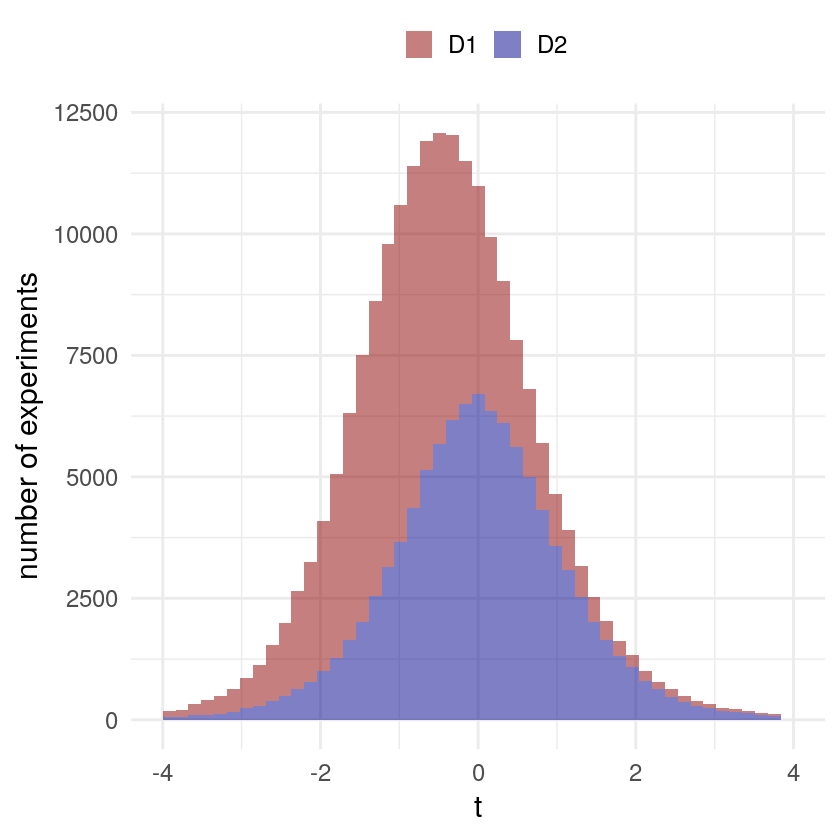

In [4]:
# 3

# draw distributions for D1 and D2



tibble(D1 = D1_exps, D2 = D2_exps) %>% 
pivot_longer(cols = c("D1","D2"), values_to = "x") %>%
ggplot(aes(x = x,fill = name)) + 
geom_histogram(alpha = .5, bins = 50, na.rm = TRUE) + xlim(c(-4,4)) +
scale_fill_manual(values = c("D1" = "darkred","D2" = "darkblue"), 
                   name = NULL) + 
theme_minimal(18) + theme(legend.position = "top") + 
labs(y = "number of experiments", x = "t")


As you can see, the distributions are different. This is because in those pretend experiments, the devices would behave differently. In our actual experiment (this treasure hunt), they didn't behave differently. They behaved exactly the same, and both behaved accurately.  However, there's no getting away from the fact that because the devices have the *potential* to behave differently in situations other than the current situation, this *potential difference* must be accounted for. They factor into the calculation of the *p* value by changing the distributions and, therefore, we need to take account of these potential events in our inferences if we want to maintain our error control properties. 

For some, the influence of imaginary events is madness. Jeffreys described this "madness" as follows:

> What the use of P implies, therefore, is that a hypothesis that may be true may be rejected because it has not predicted observable results that have not occurred. This seems a remarkable procedure [(Jeffreys, 1961, p. 385)](https://books.google.co.uk/books?hl=en&lr=&id=vh9Act9rtzQC&oi=fnd&pg=PA1&ots=feXxKZ_7gU&sig=kBgiA5I_7qciHOxy75G6H9rye7A&redir_esc=y#v=onepage&q&f=false)

## The universe of possible events

To see another example of how potential events can influence inference, let's examine a different scenario. In this scenario, we're going to make judgements about the fairness of a coin (fair coins being defined as coins that show heads with $Pr_{\mathrm{heads}}$ = 0.5). We'll use the same procedure as our treasure hunting device.  We will flip a coin that we *know* is fair a set number of times. We will 10 times again, but for no particular reason. We then just count up $x$ heads out of our total of $n$ flips. We then repeat the procedure many many times. We can use this procedure to generate a distribution of possible data. Again, we can just simulate this. 


In [5]:
# 4
# define function for flipping coins
do_flips = function(n_flips = 10, pr_heads = .5){ # set default to 10 flips with a fair coin

    # generate n_flips bernoulli trials and count number of heads
    tibble(n = n_flips) %>% 
    mutate(h = sum(purrr::rbernoulli(n,pr_heads)),t = n - h)
}

In [6]:
# 5
# run this chunk to actually run the simulations!
n_flips = 10; pr_heads = .5

all_flips = map_dfr(1:no_of_exps, function(x) do_flips(n_flips, pr_heads))

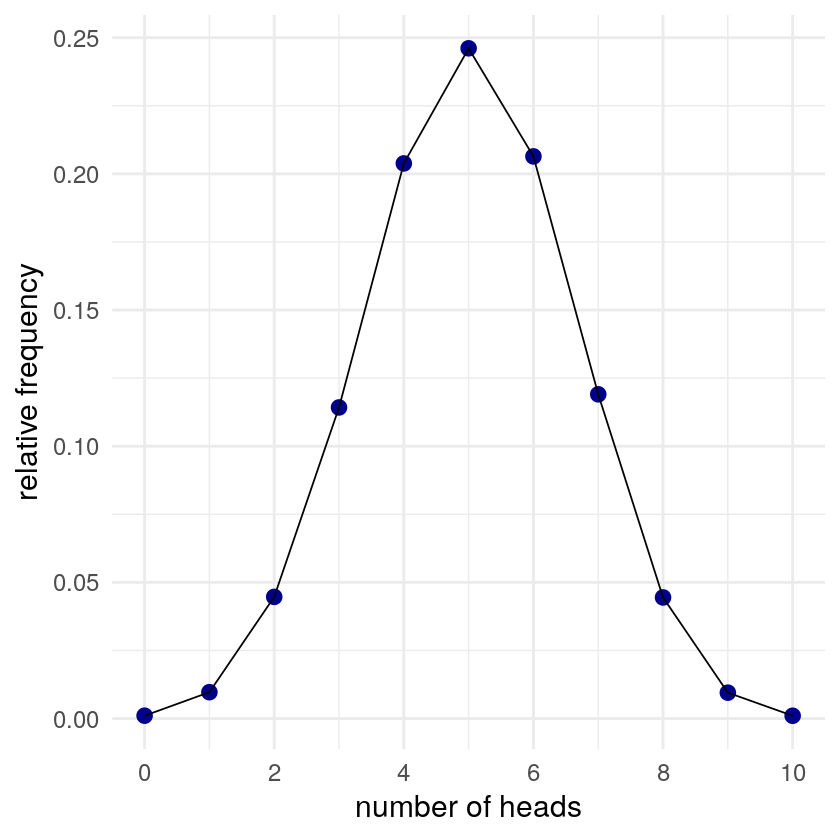

In [7]:
# 6 
# plot the distribution of results from the simulated experiments
all_flips_summary = all_flips %>% add_count(name = "total")  %>% 
    group_by(h,total) %>% summarise(d_heads = n()) %>%
    mutate(d_heads = d_heads/total) %>% ungroup()

ggplot(all_flips_summary, aes(x = h, y = d_heads)) + geom_point(size = 4, colour = "darkblue") + 
    geom_line() + theme_minimal(18) + 
    scale_x_continuous(name = "number of heads", limits = c(0,10), breaks = seq(0,10,2)) +
    scale_y_continuous(name = "relative frequency")

Armed with this distribution, we can start making judgements about actual data. To produce some real data, I flip a coin, and at the end, I count up 8 heads and 2 tails. Now you can make a judgement about whether this data is surprising or not. To do this, all you need to do is compare it to the simulated results above. 

In [8]:
# 7
# compare current results to simulated results to see whether it is surprising

x = 8 # the number of heads in our current sample
x_heads_if_fair = n_flips * pr_heads  # the average number of heads for a fair coin
distance_of_sample_from_fair = x - x_heads_if_fair # how far is this sample from the fair mean 

coin_flip_p = all_flips_summary %>% mutate(deviation = abs(mean(h) - h)) %>% 
filter(deviation >= distance_of_sample_from_fair) %>% pull(d_heads) %>% sum()

glue::glue("The *p* value for {x} heads in {n_flips} flips is {round(coin_flip_p,3)}   
This result is {if_else(coin_flip_p > 0.05, 'not surprising','surprising')} on
the assumption that the coin is fair (i.e., $Pr_{{\\mathrm{{heads}}}}$ = {pr_heads})") %>%
IRdisplay::display_markdown()

The *p* value for 8 heads in 10 flips is 0.11   
This result is not surprising on
the assumption that the coin is fair (i.e., $Pr_{\mathrm{heads}}$ = 0.5)

But save your judgement for now, because there's something that I have neglected to tell you. My plan wasn't to flip the coin 10 times. Instead, I decided that I would just flip the coin until it came up tails twice, and it just so happened that on this occasion, this meant that I flipped the coin 10 times. 

Does this fact change your inference? If our inferences are based on comparing our actual data to possible data, we need to take into account how deciding to flip the coin until it came up tails twice changes the possible data that could've been produced by this experiment. For example, on a different occasion, getting 2 tails might have only required 2 flips, or 9 flips, or 15 flips. Is it surprising that it (only) took 10 flips this time? How often would we have to flip the coin 10 or more times before we got 2 tails? To answer this we'll need to re-run the simulation, and this time only stop after we get 2 heads. 


In [9]:
# 8

# define function for new simulation. stop after stop_at heads
do_flips_until = function(stop_at = 2, pr_heads = 0.5){
    tails = 0 
    flips = 0
    while(tails <= (stop_at - 1)){
    tails = tails + purrr::rbernoulli(1,pr_heads); flips = flips + 1}
    return(flips)
}

In [10]:
# 9
# run the actual simulations
stop_at = 2; pr_heads = .5

all_flips_v2 = map_dbl(1:no_of_exps, function(x) do_flips_until(stop_at, pr_heads))

We now can count up the relative frequency of getting 2 heads after 2 flips, after 3 flips, 4 flips, and so on. And we can draw a plot of this distribution. 


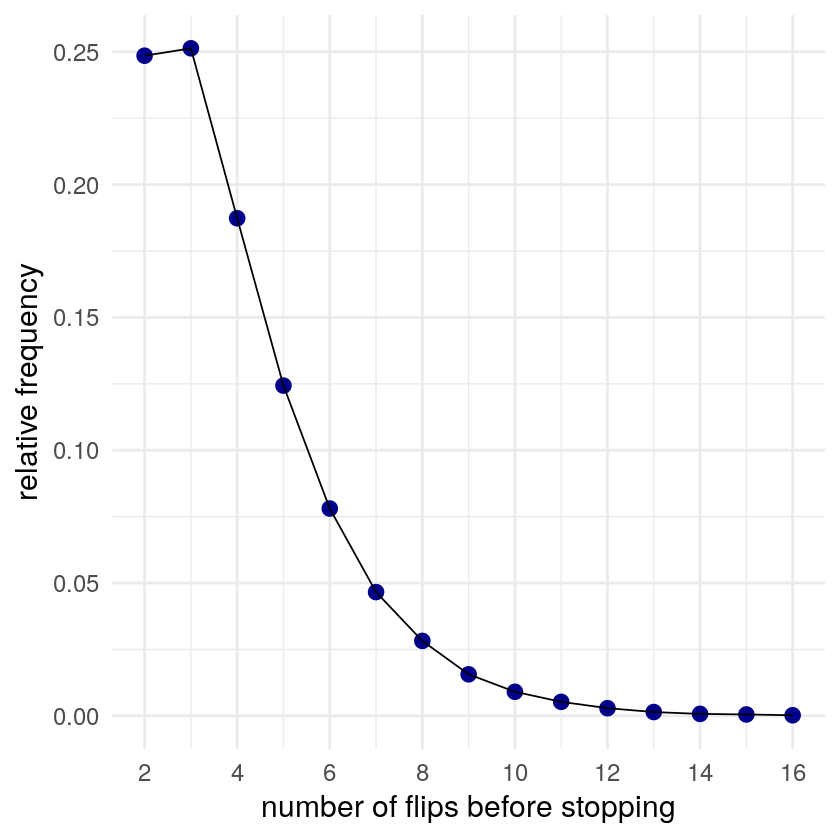

In [11]:
# 10 
# plot the distribution of results from the simulation experiments

# make a frequency table
all_flips_v2_freq = summarise(group_by(enframe(all_flips_v2),value), n = n()) %>%
    set_colnames(c("flips","counts")) %>% 
    mutate(freq = counts / sum(counts), 
           flips = as.numeric(flips),
           counts = as.numeric(counts), 
           freq = as.numeric(freq)) 

# make the actual plot
all_flips_v2_freq %>% ggplot(aes(x = flips, y = freq)) + geom_point(size = 4, colour = "darkblue", na.rm =  TRUE) + 
    geom_line(na.rm = TRUE) + theme_minimal(18) + 
    scale_x_continuous(name = "number of flips before stopping", limits = c(2,16), breaks = seq(2,16,2)) +
    scale_y_continuous(name = "relative frequency")

From this new distribution, we can now ask: How often would you need to flip a fair coin 10 or more times before you got two heads? That is, is it surprising that we had to flip it this many times? Let's see how the inference differs.


In [12]:
# 11
# calculate a p value based on our new simulations
observed_flips = 10 # how many flips did we observe

coin_flip_v2_p = all_flips_v2_freq %>% filter(flips >= observed_flips) %>% pull(freq) %>% sum()

glue::glue("For a fair coin ($Pr_{{\\mathrm{{heads}}}}$ = {pr_heads}), 
about {round(100 - coin_flip_v2_p * 100,2)}% of experiments would end
before we got to {observed_flips} flips.   
Only {round(coin_flip_v2_p * 100,2)}% of experiments would run this long.  
Therefore, our result is {if_else(coin_flip_v2_p < 0.05, 'surprising!','not surprising.')}") %>%
IRdisplay::display_markdown()

For a fair coin ($Pr_{\mathrm{heads}}$ = 0.5), 
about 97.99% of experiments would end
before we got to 10 flips.   
Only 2.01% of experiments would run this long.  
Therefore, our result is surprising!

What these two examples show is that even when presented with the **same data** the inferences will be different if the realm of **possible**, but **not actual** results are different. That is, non-existent results influence our inferences. Based on this fact, we can go ahead to imagine even more ridiculous examples. 

For example, imagine that I build a device that is going to decide whether 1) to flip the coin n times or 2) flip it until it comes up tails x times. The device makes a decision, flips the coin, and it just so happens on this occasion to show 8 heads and 2 tails. How do I analyse this set of data? Does the realm of possible data include the machine that makes the decision? What if I know what decision the device made? Do I still have to take into account the experiment that wasn't performed? And what if I have the results of two experiments, one that was performed as part of a mixture (using a machine to decide which of the two experiments would be performed) and one which was performed not as part of a mixture. If they yield the same data, then does the fact that one was part of a mixture mean that the conclusions should be different? For a frequentist, these can be pretty uncomfortable questions!